# <u><center> Project 5: Part 3 Core
* Authored By: Eric N. Valdez
* Date: 03-17-2024

# <u>Imports:

In [1]:
#Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Deep learning tools
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

#Evaluation tools
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tensorflow import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn import set_config, config_context
set_config(transform_output='pandas')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# <u>Custome Functions:

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

# <u>Task:
* Build a small neural Network (with only 1 hidden layer)
   * Ensure the Final layer is appropriate for your task (number of units and activation function)
   * Fit it for 50 epochs
       *  Use Early Stopping callbacks
           * Start with patience = 5 monitoring val_accuracy.
       * Use a validation_split of 2
       * Save the history and visualize it.  
    * Evaluate the model using sklearn evaluation metrics:
        * Confusion Matrix
        * Classification Report
        * You are Welcome to use the custom  evaluation functions  

* Tune at least 3 parameters with Keras tuner:
    * Include a dropout layer and adjust the dropout rate
    * Number of units
    * Optimizer
    * Learning rates 
* Evaluate your best model on unseen test data

# <u>Load Data:

In [4]:
# Loading clean data that I created from Part1
df = pd.read_csv('Data/clean_MetSyndr.csv', index_col = 'seqn')
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.00000,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.00000,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.00000,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.00000,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,4005.25394,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 62161 to 71915
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2401 non-null   object 
 3   Income             2401 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2401 non-null   float64
 6   BMI                2401 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(5), object(4)
memory usage: 281.4+ KB


In [6]:
# Checking for any duplicates
df.duplicated().sum()

0

In [7]:
# Checking to make sure my data is clean
df.isna().sum()

Age                  0
Sex                  0
Marital              0
Income               0
Race                 0
WaistCirc            0
BMI                  0
Albuminuria          0
UrAlbCr              0
UricAcid             0
BloodGlucose         0
HDL                  0
Triglycerides        0
MetabolicSyndrome    0
dtype: int64

In [8]:
df['MetabolicSyndrome']=df['MetabolicSyndrome'].replace({'No MetSyn': 0, 'MetSyn': 1})
df['MetabolicSyndrome'].value_counts()

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

# <u>Preprocess Data for Machine Learning

In [9]:
# Train Test Split
X= df.drop(columns='MetabolicSyndrome')
y=df['MetabolicSyndrome'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [10]:
ordcol = X_train[['Albuminuria']].columns
catcol = X_train.select_dtypes('object').columns
numcol = X_train.select_dtypes('number').drop(columns=ordcol).columns

In [11]:
#Instantiate the transformers
from sklearn.impute import KNNImputer
scaler=StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
knnimpute= KNNImputer(n_neighbors=3)
oheimpute = SimpleImputer(strategy='constant', fill_value='none')

In [12]:
#Create pipelines
num_pipe= make_pipeline(knnimpute, scaler)
cat_pipe= make_pipeline(oheimpute, ohe)

In [13]:
num_tuple= ("Numeric", num_pipe, numcol)
cat_tuple=("Catagorical", cat_pipe, catcol)
ord_tuple= ("Ordinal", scaler, ordcol)

In [14]:
# preprocessor.fit(X_train)
# X_train_tf=preprocessor.transform(X_train)
# X_test_tf=preprocessor.transform(X_test)

In [15]:
# fitting data
preprocessor = ColumnTransformer([num_tuple, cat_tuple, ord_tuple], remainder='passthrough')
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## `Model 1`

In [16]:
input_shape = X_train.shape[1]

In [17]:
def build_model1():
    model = Sequential()

    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss ='bce', optimizer = 'adam', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    
    return model

model1 = build_model1()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2500      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


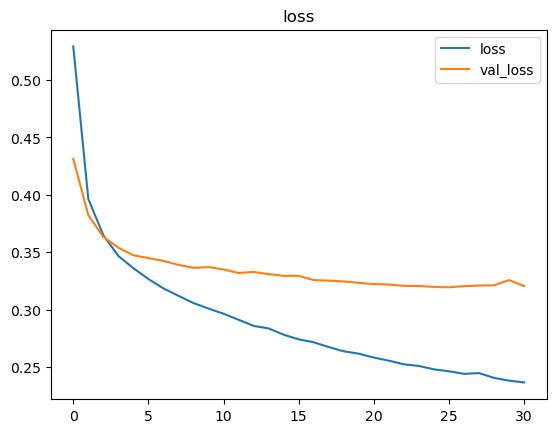

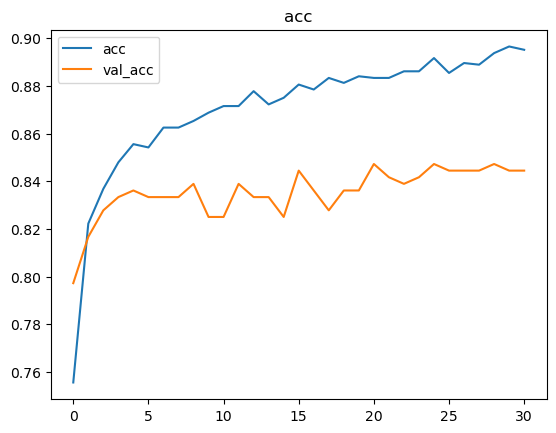

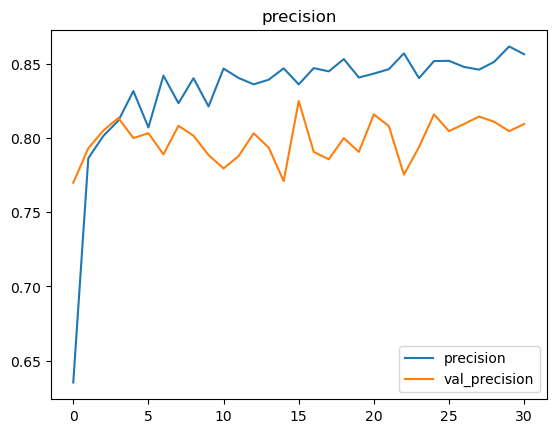

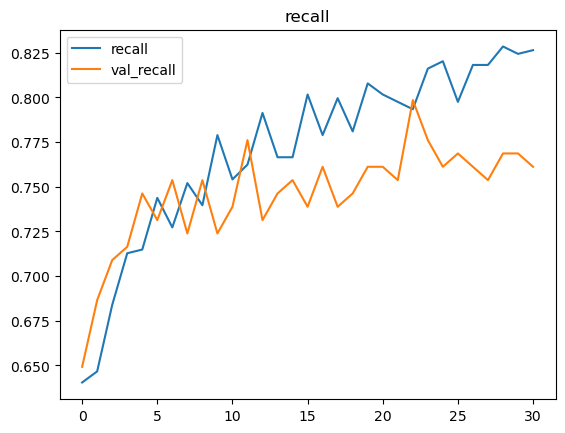

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history1 = model1.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])
plot_history(history1);

19/19 [==============================] - 0s 2ms/step
Class Model-1 Train 

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1182
           1       0.86      0.81      0.83       618

    accuracy                           0.89      1800
   macro avg       0.88      0.87      0.88      1800
weighted avg       0.89      0.89      0.89      1800



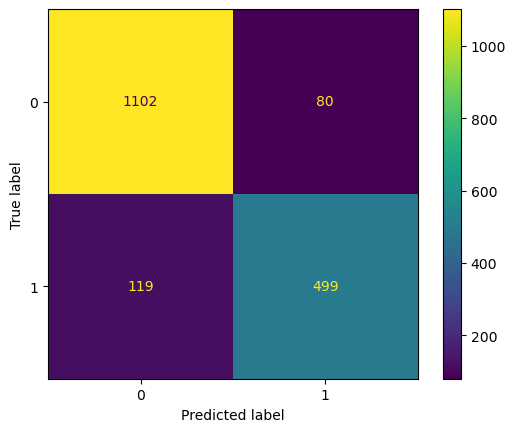

Class Model-1 Test 

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       397
           1       0.80      0.72      0.76       204

    accuracy                           0.85       601
   macro avg       0.83      0.81      0.82       601
weighted avg       0.84      0.85      0.84       601



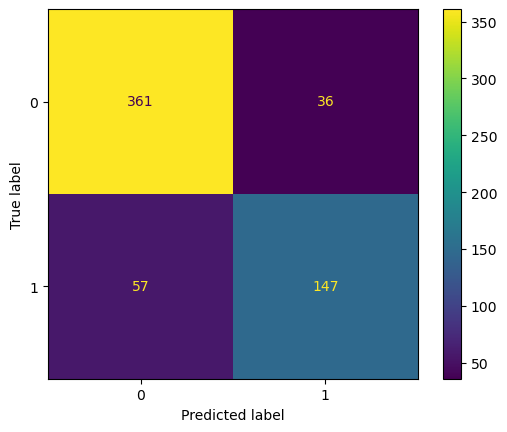

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Class Model-1 Train,0.861831,0.807443,0.833751,0.889444
Class Model-1 Test,0.803279,0.720588,0.759690,0.845258


In [19]:
# Evaluate model

train_pred = np.rint(model1.predict(X_train))
test_preds = np.rint(model1.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='Class Model-1 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='Class Model-1 Test')
scores = pd.concat([train_scores, test_scores])
scores

## `Model 2: Tune Parameters with Keras Tuner`

In [20]:
# Adding a Dropout layer at .2
def build_model2():
    model = Sequential()

    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss ='bce', optimizer = 'adam', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    
    return model

model2 = build_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               2500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Creating an early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history2 = model2.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

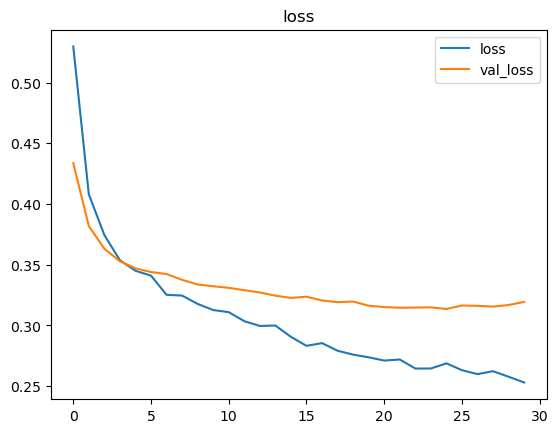

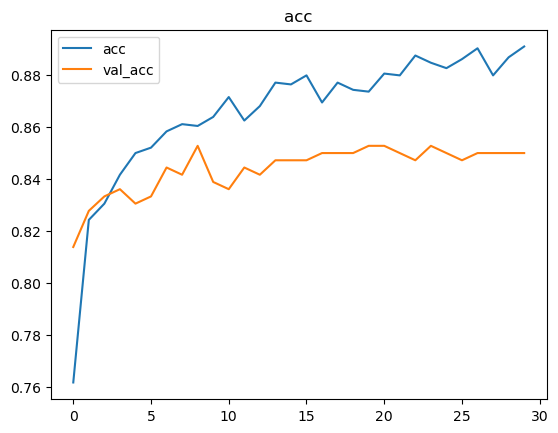

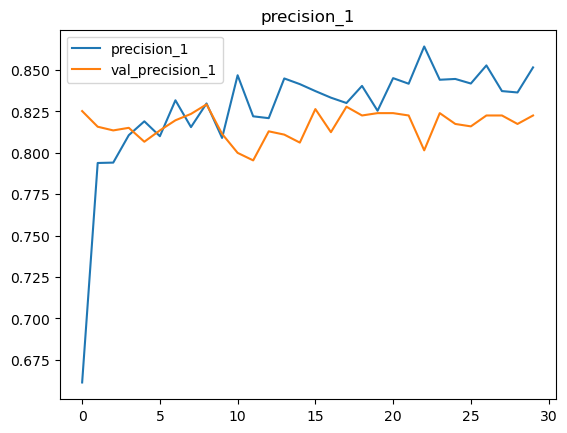

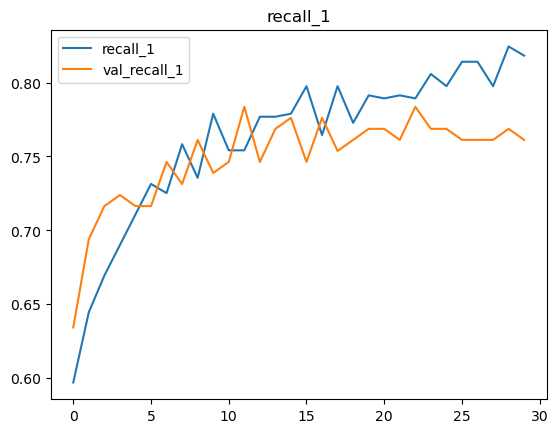

In [22]:
# Plot learning
plot_history(history2);

19/19 [==============================] - 0s 2ms/step
Class Model-2 Train 

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1182
           1       0.86      0.81      0.83       618

    accuracy                           0.89      1800
   macro avg       0.88      0.87      0.87      1800
weighted avg       0.89      0.89      0.89      1800



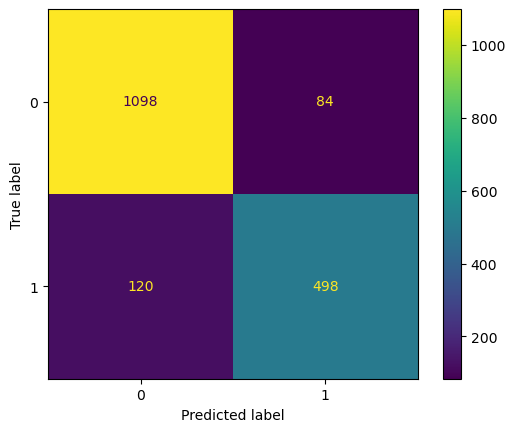

Class Model-2 Test 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       397
           1       0.79      0.75      0.77       204

    accuracy                           0.85       601
   macro avg       0.83      0.82      0.83       601
weighted avg       0.85      0.85      0.85       601



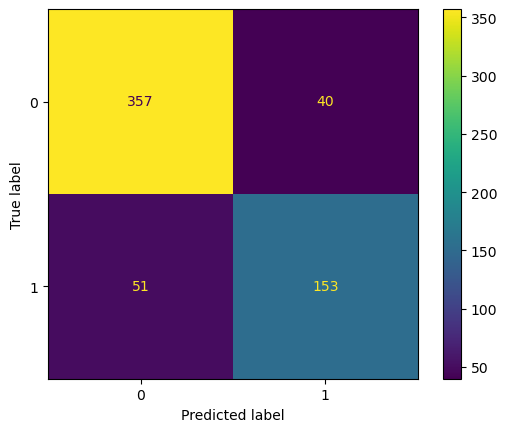

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Class Model-1 Train,0.861831,0.807443,0.833751,0.889444
Class Model-1 Test,0.803279,0.720588,0.759690,0.845258
Class Model-2 Train,0.855670,0.805825,0.830000,0.886667
Class Model-2 Test,0.792746,0.750000,0.770781,0.848586


In [23]:
# Evaluate model

train_pred = np.rint(model2.predict(X_train))
test_preds = np.rint(model2.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='Class Model-2 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='Class Model-2 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

<!-- ## `Evaluate Model`
- The model 1 has an accuracy score of 0.81 
- The model 2 using keras tuner has an accuracy score of 0.81 on the test model 1 and 2 are similar
- Of the models the default model performs the best
    - Both models show a point where the models become overfit
        - Perhaps using a lower patience during early stopping would prevent this. -->

## `Model 3`
- ### Reducing Neurons

In [24]:
# Building Model-3
def build_model3():
    model = Sequential()

    model.add(Dense(50, input_dim=input_shape, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss ='bce', optimizer = 'adam', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    
    return model

model3 = build_model3()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                1250      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history3 = model3.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

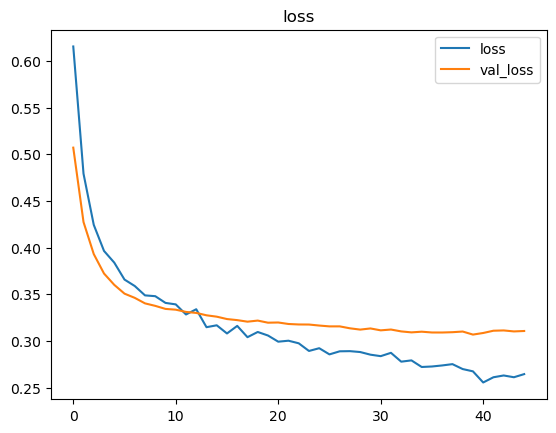

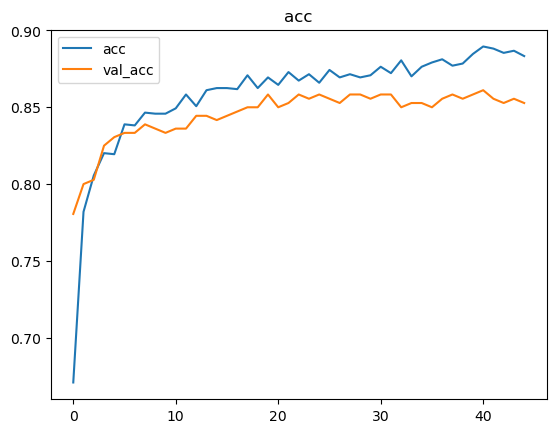

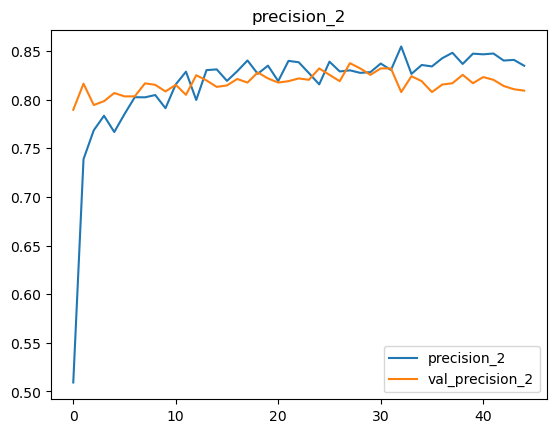

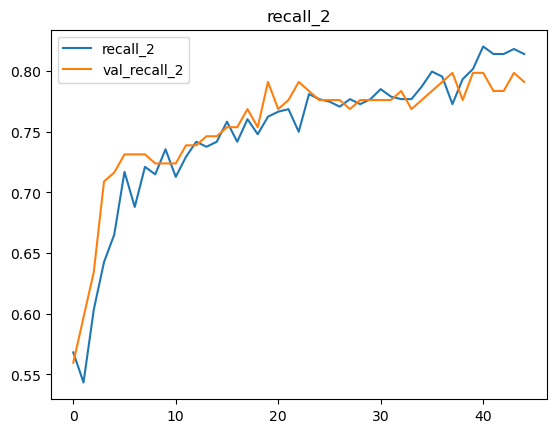

In [26]:
# Plot learning
plot_history(history3);

19/19 [==============================] - 0s 2ms/step
Class Model-3 Train 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1182
           1       0.84      0.80      0.82       618

    accuracy                           0.88      1800
   macro avg       0.87      0.86      0.87      1800
weighted avg       0.88      0.88      0.88      1800



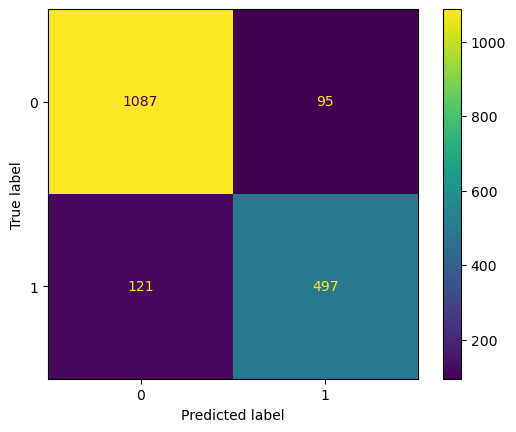

Class Model-3 Test 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       397
           1       0.78      0.74      0.76       204

    accuracy                           0.84       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.84      0.84      0.84       601



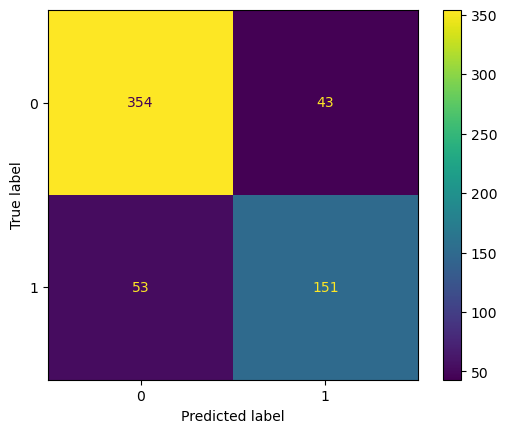

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Class Model-1 Train,0.861831,0.807443,0.833751,0.889444
Class Model-1 Test,0.803279,0.720588,0.759690,0.845258
Class Model-2 Train,0.855670,0.805825,0.830000,0.886667
Class Model-2 Test,0.792746,0.750000,0.770781,0.848586
Class Model-3 Train,0.839527,0.804207,0.821488,0.880000
Class Model-3 Test,0.778351,0.740196,0.758794,0.840266


In [27]:
# Evaluate model

train_pred = np.rint(model3.predict(X_train))
test_preds = np.rint(model3.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='Class Model-3 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='Class Model-3 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

<!-- # Including a dropout layer did not improve the model. Let's find out if we are using the best optimizer. -->

In [28]:
# Building a Model-4
def build_model4():
    model = Sequential()

    model.add(Dense(50, input_dim=input_shape, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss ='bce', optimizer = 'rmsprop', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
    
    return model

model4 = build_model4()
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 50)                1250      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


## `Model 4:`
- ### Changing the optimizer to rmsprop

In [29]:
# Fit, copile you model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history4 = model4.fit(X_train, y_train,
                        validation_split = .2,
                        epochs=50,
                        verbose=0, callbacks = [early_stop])

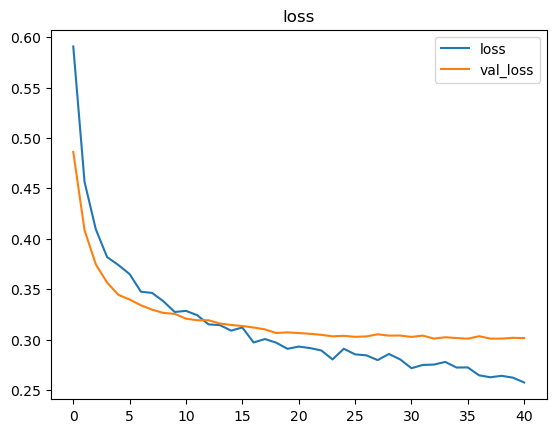

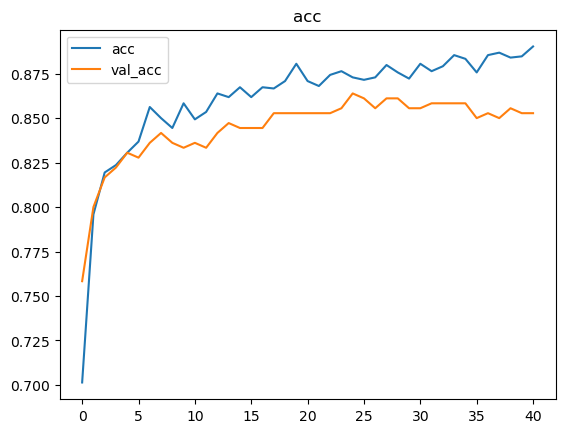

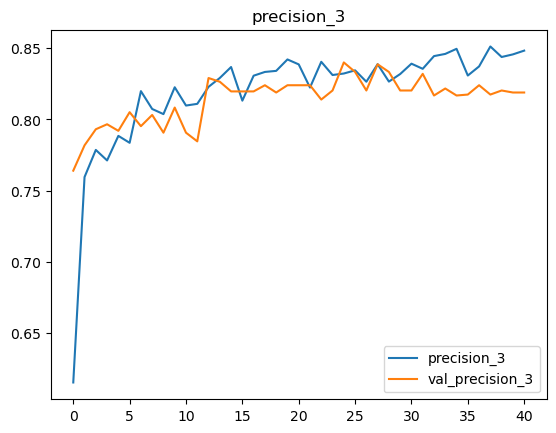

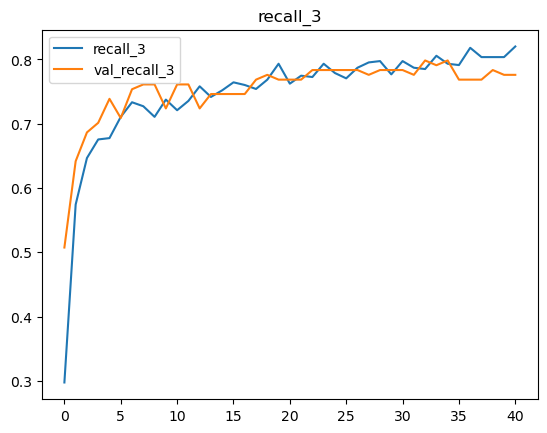

In [30]:
# Apply the custom function to see how your model is doing
plot_history(history4);

19/19 [==============================] - 0s 704us/step
Class Model-4 Train 

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1182
           1       0.85      0.80      0.83       618

    accuracy                           0.88      1800
   macro avg       0.87      0.86      0.87      1800
weighted avg       0.88      0.88      0.88      1800



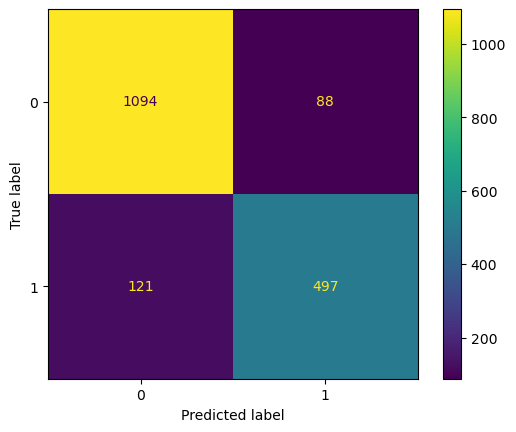

Class Model-4 Test 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       397
           1       0.78      0.74      0.76       204

    accuracy                           0.84       601
   macro avg       0.83      0.82      0.82       601
weighted avg       0.84      0.84      0.84       601



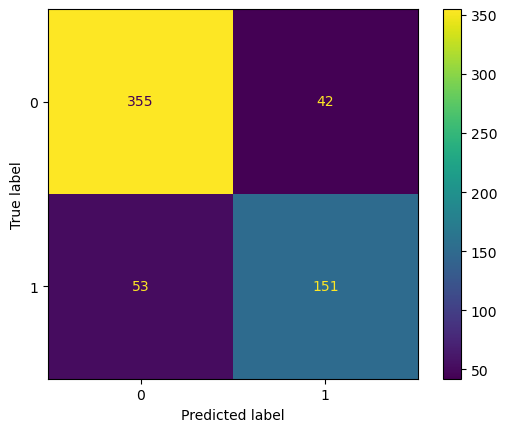

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Class Model-1 Train,0.861831,0.807443,0.833751,0.889444
Class Model-1 Test,0.803279,0.720588,0.759690,0.845258
Class Model-2 Train,0.855670,0.805825,0.830000,0.886667
Class Model-2 Test,0.792746,0.750000,0.770781,0.848586
Class Model-3 Train,0.839527,0.804207,0.821488,0.880000
Class Model-3 Test,0.778351,0.740196,0.758794,0.840266
Class Model-4 Train,0.849573,0.804207,0.826268,0.883889
Class Model-4 Test,0.782383,0.740196,0.760705,0.841930


In [31]:
## Evaluate model

train_pred = np.rint(model4.predict(X_train))
test_preds = np.rint(model4.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='Class Model-4 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='Class Model-4 Test')
scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

## `Model 5`
- trying to see what the difference is with an added hidden layer

In [38]:
# use all features as input using input_dim
input_dim = X_train.shape[1]

# Instantiate your sequential model
model5 = Sequential()

# Add first hidden layer
model5.add(Dense(100, activation='relu', input_dim=input_dim, name='h1'))
model5.add(Dropout(.2))
# Add second hidden layer
model5.add(Dense(100, activation='relu', name='h2'))
model5.add(Dropout(.2))

# Add output layer with 1 node
model5.add(Dense(1, activation='sigmoid', name ='Output'))

# Compile
model5.compile(loss ='bce', optimizer = 'adam', metrics = ['acc', metrics.Precision(),
                                                               metrics.Recall()])
# Check summary of network
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               2500      
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 h2 (Dense)                  (None, 100)               10100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 12,701
Trainable params: 12,701
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Fit your model similar to L2W3 solution model with no earlystop

history5 = model5.fit(X_train, y_train,
                        validation_data = (X_test, y_test),
                        epochs = 50)

Epoch 1/50
57/57 [==============================] - 1s 17ms/step - loss: 0.1117 - acc: 0.9617 - precision_5: 0.9567 - recall_5: 0.9304 - val_loss: 0.5486 - val_acc: 0.8353 - val_precision_5: 0.7612 - val_recall_5: 0.7500
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1017 - acc: 0.9572 - precision_5: 0.9398 - recall_5: 0.9353 - val_loss: 0.5723 - val_acc: 0.8353 - val_precision_5: 0.7807 - val_recall_5: 0.7157
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1005 - acc: 0.9617 - precision_5: 0.9478 - recall_5: 0.9401 - val_loss: 0.5700 - val_acc: 0.8386 - val_precision_5: 0.7956 - val_recall_5: 0.7059
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0958 - acc: 0.9639 - precision_5: 0.9555 - recall_5: 0.9385 - val_loss: 0.5694 - val_acc: 0.8336 - val_precision_5: 0.7680 - val_recall_5: 0.7304
Epoch 5/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0856 - acc: 0.9700 - precision_5: 0.9623 - re

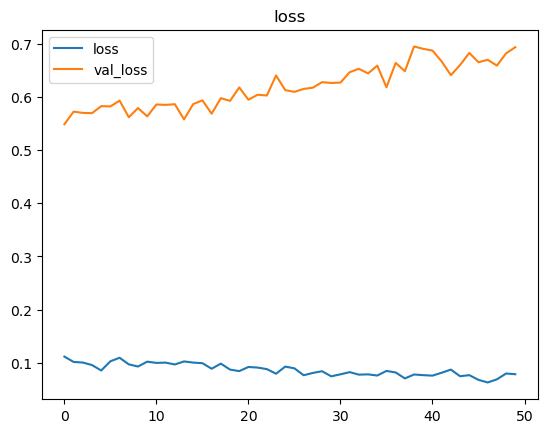

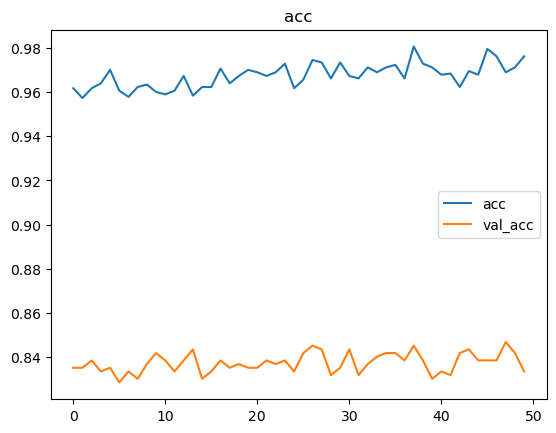

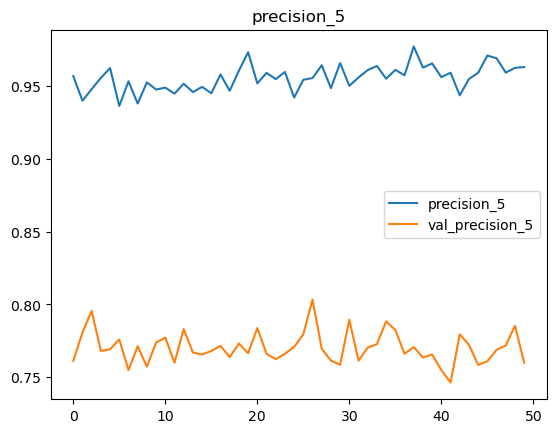

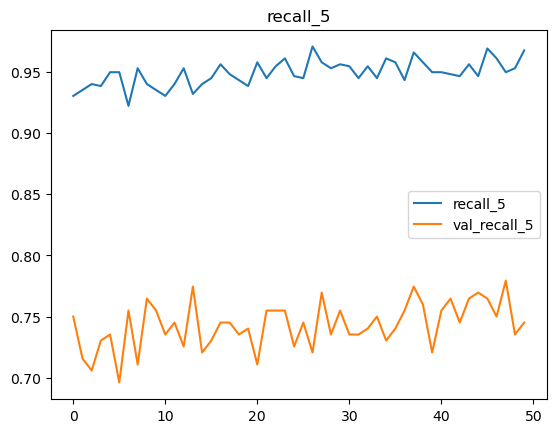

In [44]:
# Apply the custom function to see how your model is doing
plot_history(history5);

19/19 [==============================] - 0s 2ms/step
Class Model-5 Train 

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1182
           1       1.00      0.99      0.99       618

    accuracy                           0.99      1800
   macro avg       1.00      0.99      0.99      1800
weighted avg       1.00      0.99      0.99      1800



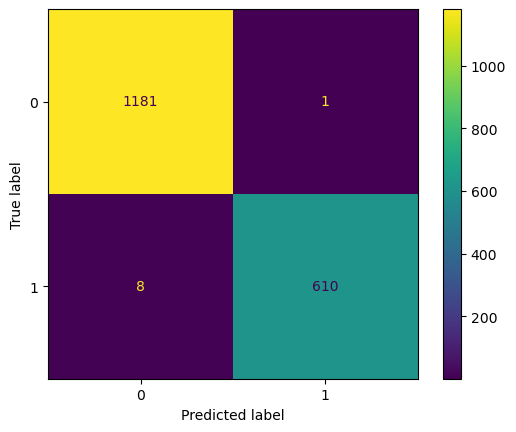

Class Model-5 Test 

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       397
           1       0.76      0.75      0.75       204

    accuracy                           0.83       601
   macro avg       0.82      0.81      0.81       601
weighted avg       0.83      0.83      0.83       601



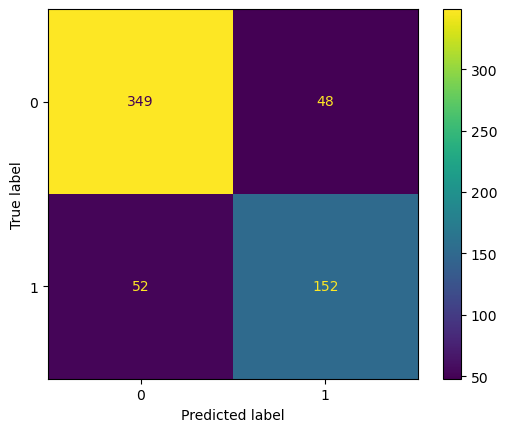

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
Class Model-1 Train,0.861831,0.807443,0.833751,0.889444
Class Model-1 Test,0.803279,0.720588,0.759690,0.845258
Class Model-2 Train,0.855670,0.805825,0.830000,0.886667
Class Model-2 Test,0.792746,0.750000,0.770781,0.848586
Class Model-3 Train,0.839527,0.804207,0.821488,0.880000
Class Model-3 Test,0.778351,0.740196,0.758794,0.840266
Class Model-4 Train,0.849573,0.804207,0.826268,0.883889
Class Model-4 Test,0.782383,0.740196,0.760705,0.841930
Class Model-5 Train,0.998363,0.987055,0.992677,0.995000


In [46]:
# Evaluate model

train_pred = np.rint(model5.predict(X_train))
test_preds = np.rint(model5.predict(X_test))

train_scores = eval_classification(y_train,
                                   train_pred,
                                   name='Class Model-5 Train')

test_scores = eval_classification(y_test,
                                  test_preds,
                                  name='Class Model-5 Test')
scores =pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

## The Best model out of the 5 that I did is model 1 with a precision of 80, recall was the lowest of the 5 at 72, 75 was the F1 which seemed like 3 other models had same score. Accuracy was at a 84. Model 5 had a good trining score but the loss was to high